#Overview
After previous visual testing, the best fence segmentation methods were evaluated against ground truth masks.
The notebook compares the following methods agaisnt 4 ground truth's:
* Standard Hough line transform
* Probability Hough line transform
* Temperature Thresholding
* Hybrid Approach: detect with temperature and segment with hough line standard

This notebook provides the quantitative analysis.

#Imports and Pre-processing
Importing all the necessary libaries and converting CSV files image to standard 0-255 PNG image for fence segmentation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.restoration import inpaint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Saving Image
This is only necessary to get a PNG (instead of CSV) image to create the ground truth fence mask (manually label where the fence is).

In [6]:
def csv_to_image(csv_file, output_image_frame):
    data = pd.read_csv(csv_file, header=None).to_numpy()
    min_val, max_val = data.min(), data.max()
    normalized_frame = ((data - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    cv2.imwrite(output_image_frame, normalized_frame)
    print(f"Saved normalised frame to {output_image_frame}")

#Note these are old paths
#Image 1: 4826
#csv_file = '/content/drive/MyDrive/Explicit Neural Network SIREN/Fence Images to test/4826_1004_labeledset.csv'

#Image 2: 8402
#csv_file = "/content/drive/MyDrive/Explicit Neural Network SIREN/Fence Images to test/8402_FLIR1041_labeleddata.csv"

#Image 3: 25994
#csv_file = "/content/drive/MyDrive/Explicit Neural Network SIREN/Fence Images to test/25994_shortsequence_1003.csv"

#Image 4: 23151
#csv_file= "/content/drive/MyDrive/January 29th/Extra Monkey pictures testing out/23151.csv"

#output_image_file = 'thermal_image.png'  # Output grayscale image
#csv_to_image(csv_file, output_image_file)



#All Fence Detection methods

In [38]:
#Used to normalise thermal image
def norm(csv_frame):
  thermal_image = pd.read_csv(csv_frame, header=None).to_numpy()
  normalized_thermal_image = cv2.normalize(thermal_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  #plt.figure(figsize=(3, 3))
  #plt.imshow(thermal_image, cmap='gray') #for testing
  #plt.show()
  return normalized_thermal_image


In [25]:
#Standard Hough Line Transform method
def hough_stand(normalized_image):
  #code below explain in previous notebooks (Same as with other functions)
  #only new code is explained
  blur = cv2.GaussianBlur(normalized_image, (7, 7), 0)

  canny_edges = cv2.Canny(blur, 20, 120)
  lines = cv2.HoughLines(canny_edges, rho=1, theta=np.pi / 180, threshold=75)

  color_img = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

  mask_standard = np.zeros_like(normalized_image)

  if lines is not None:
    for line in lines:
      rho, theta = line[0]
      a, b = np.cos(theta), np.sin(theta)
      x0, y0 = a * rho, b * rho
      x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
      x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

      cv2.line(color_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.line(mask_standard, (x1, y1), (x2, y2), 255, 2)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  dilated_mask_standard = cv2.dilate(mask_standard, kernel, iterations=1) #dilation

  return dilated_mask_standard


In [26]:
#Probability Hough Line transform:
def hough_prob(normalized_image):
  blurred_image = cv2.GaussianBlur(normalized_image, (7, 7), 0)
  canny_edges = cv2.Canny(blurred_image, threshold1=30, threshold2=180)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  closed_edges = cv2.morphologyEx(canny_edges, cv2.MORPH_CLOSE, kernel)

  lines = cv2.HoughLinesP(canny_edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=0, maxLineGap=10000)

  image_showing_lines = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)
  mask_prob = np.zeros_like(normalized_image)

  for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(mask_prob, (x1, y1), (x2, y2), 255, 3)
      cv2.line(image_showing_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

  dilated_mask_hough_prob = cv2.dilate(mask_prob, kernel, iterations=1)
  return dilated_mask_hough_prob


In [27]:
#Temperature Threshold:
def temp_thresh(csv_file):
  data = pd.read_csv(csv_file, header=None)
  thermal_frame = data.to_numpy()

  lower_threshold = 24
  upper_threshold = 28
  fence_mask = (thermal_frame >= lower_threshold) & (thermal_frame <= upper_threshold)
  #Norm
  fence_mask = fence_mask.astype(np.uint8) * 255
  kernel = np.ones((3, 3))
  #dilate
  dilated_mask_temp = cv2.dilate(fence_mask, kernel, iterations=3)

  return dilated_mask_temp





In [28]:
#Hybrid Approach: combining temp and hough
def hybrid(csv_file):
  data = pd.read_csv(csv_file, header=None)
  thermal_csv = data.to_numpy()

  lower_threshold = 24
  upper_threshold = 26

  fence_mask = (thermal_csv >= lower_threshold) & (thermal_csv <= upper_threshold)
  fence_mask_norm = (fence_mask * 255).astype(np.uint8)
  blur = cv2.GaussianBlur(fence_mask_norm, (7, 7), 0)
  edges = cv2.Canny(blur, 20, 120)

  hough_lines_std = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=75)

  normalized_image = norm(csv_file)
  color_img = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

  mask_hybrid = np.zeros_like(normalized_image)

  if hough_lines_std is not None:
      for line in hough_lines_std:
          rho, theta = line[0]
          a, b = np.cos(theta), np.sin(theta)
          x0, y0 = a * rho, b * rho
          x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
          x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))

          cv2.line(color_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
          cv2.line(mask_hybrid, (x1, y1), (x2, y2), 255, 2)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
  dilated_mask_combined = cv2.dilate(mask_hybrid, kernel, iterations=1)
  return dilated_mask_combined


#Comparing Masks to Ground_truth
Here we take our groundtruth mask (4 images tested total; not much but since our focus will be on nose tracking that is where rigorous testing will be).


In [29]:
#Intersection Over Union IOU:
#Calculate IoU between predicted fence mask and the ground truth fence mask
def iou_score(mask, ground_truth):
  #Since the software used to manually annotate makes mask range from 0-1
  #have to convert to 0-255
  ground_truth_norm = ground_truth * 255

  #Intersection calculation
  intersection = np.logical_and(mask == 255, ground_truth_norm == 255).sum()
  #Union calculation
  union = np.logical_or(mask == 255, ground_truth_norm == 255).sum() #where they are both 255/white/ fence

  #Compute IoU
  iou = intersection / union if union > 0 else 0
  return iou

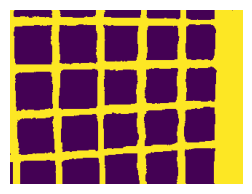

In [30]:
#Image 1 test:
image_path="/content/drive/MyDrive/Final Code/Fence Ground_truth Masks/mask_4.tif"
#Note: this is just a test example but there are all 4 to test in Fence Ground_truth Masks folder
image_ground_truth = mpimg.imread(image_path)
plt.figure(figsize=(3, 3))
plt.imshow(image_ground_truth)
plt.axis('off')
plt.show()

In [31]:
def compare(csv_num):
  """Function a csv frame and produces a fence mask for each using the different
  methods. Then calcualtes the IoU for those methods masks and the
  ground-truth masks."""
  img_1 = norm(csv_num)
  mask_hough_S = hough_stand(img_1)
  mask_hough_P = hough_prob(img_1)
  mask_temp = temp_thresh(csv_1)
  mask_combined = hybrid(csv_1)

  hough_standard_iou = iou_score(mask_hough_S, image_ground_truth)
  hough_prob_iou = iou_score(mask_hough_P, image_ground_truth)
  temp_iou = iou_score(mask_temp, image_ground_truth)
  combined_iou = iou_score(mask_combined, image_ground_truth)

  #print all results:
  #to 4 decimal places
  print(f"IoU for temp: {temp_iou:.4f}")
  print(f"IoU for hough Standard: {hough_standard_iou:.4f}")
  print(f"IoU for hough Probability: {hough_prob_iou:.4f}")
  print(f"IoU for Combined temp + hough: {combined_iou:.4f}")

  return hough_standard_iou, hough_prob_iou, temp_iou, combined_iou


In [39]:
#Input orignal csv file for that grouth truth mask
#Also found in Fence Ground_truth Masks but ends with .csv not TIF!!!
csv_1 = "/content/drive/MyDrive/Final Code/Fence Ground_truth Masks/4.csv"
a, b, c,d = compare(csv_1)

IoU for temp: 0.5785
IoU for hough Standard: 0.5685
IoU for hough Probability: 0.4981
IoU for Combined temp + hough: 0.5940


#Plotting the average

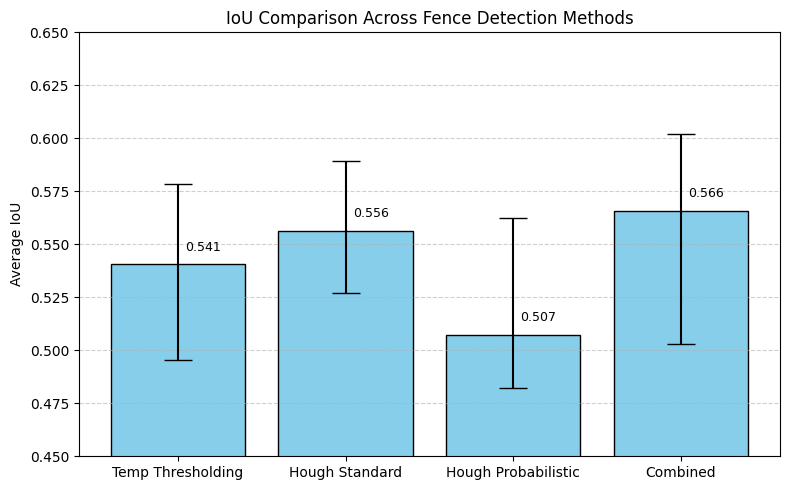

In [40]:
#Plotting the average IoU's
temp = [0.4954, 0.5100, 0.5783, 0.5785]
hough_stand = [0.5272, 0.5893, 0.5400, 0.5685]
hough_prob = [0.4822, 0.5624, 0.4860, 0.4981]
combined = [0.5032, 0.6020, 0.5645, 0.5940]

methods = ['Temp Thresholding', 'Hough Standard', 'Hough Probabilistic', 'Combined']
all_methods = [temp, hough_stand, hough_prob, combined]

#For each method in lists of lists (all_methods) find the mean, minium, and maximum values
means = [np.mean(x) for x in all_methods]
mins = [np.min(x) for x in all_methods]
maxs = [np.max(x) for x in all_methods]

#Calculate error bars:
#To find where to draw them for each method,
#Find the distance from mean to minium and from mean to maximum:
#top = max - mean, bottom = mean - min
error_lines = [ [mean - min_, max_ - mean] for mean, min_, max_ in zip(means, mins, maxs) ]
error_lines = np.array(error_lines).T

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, means, yerr=error_lines, capsize=10, color='skyblue', edgecolor='black')

plt.ylabel("Average IoU")
plt.title("IoU Comparison Across Fence Detection Methods")
plt.ylim(0.45, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Put the average number ontop of bar
for bar, mean in zip(bars, means):
    height = bar.get_height()
    #3 decimal places
    plt.text(bar.get_x() + bar.get_width() / 2 +0.15, height + 0.005, f"{mean:.3f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
#saving
plt.savefig("fence_Detect.pdf", dpi=600, bbox_inches='tight')
plt.show()
